In [117]:
import numpy as np
import pandas as pd
from scipy.special import gammaln
from scipy.special import digamma
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [118]:
##The simulation for multinomial topic model

#Factor simulation
def simu_fact(m,k):
    F=np.zeros((m,k))
    for j in range(m):
        u=np.abs(np.random.normal(0, 3, 1))-5
        s=np.exp(-u/3)
        a=np.random.uniform(low=0,high=1,size=k)
        z=(a>=0.2)*np.random.normal(u, s/10, k)+(a < 0.2) * np.random.normal(u, s, k)
        F[j,] = np.exp(np.maximum(-5,z))
    F=F/(np.sum(F,axis=0)+1e-8)
    return F

#Loading and topics simulation
def simu_load(n,k):
    L=np.zeros((n,k))
    L[:,0]=np.random.uniform(low=0,high=2,size=n)
    maj_top=np.zeros(n)
    for j in range(n):
        js=random.sample(range(1, k), 2)
        j1=js[0]
        j2=js[1]
        L[j,j1]=1
        L[j,j2]=0.1
        maj_top[j]=j1
    maj_top=maj_top.astype(int)
    L=L/np.sum(L,axis=1,keepdims=True)
    return maj_top, L

#Mutinomial trial simulation
def simu_size(n):
    return np.ceil(np.random.normal(3,0.2,n)).astype(int)

#Mutinomial count matrix generation
def simu_multi_counts(L,F,sizes):
    n=L.shape[0]
    m=F.shape[0]
    X=np.zeros((n,m))
    P=L@F.T
    for j in range(n):
        X[j,] = np.random.multinomial(sizes[j],P[j,])
    return X


In [119]:
##Topic visualization
def topic_plot(L,ord_loading,top_color,plotitle,k):
    df = pd.DataFrame(L)
    #Sort as the order 
    df = df.iloc[ord_loading]   
    plt.figure(figsize=(10, 6))
    palette = sns.color_palette(top_color, n_colors=k)
    sns.heatmap(df, cmap=palette, cbar_kws={'label': 'Loadings'})
    
    plt.xticks(ticks=np.arange(len(df.columns)), labels=np.arange(1, len(df.columns) + 1), rotation=0)
    plt.xlabel("Topics")
    plt.title(plotitle)
    
    plt.xticks(np.arange(0, len(df.columns), 1)) 

    plt.show()

In [120]:
#Poisson NMF matrix generation
def generate_poicounts(L, F): 
    n = L.shape[0]
    m = F.shape[0]
    tcross_result=np.dot(L,F.T)
    result_matrix = np.random.poisson(tcross_result, (n, m))

    return result_matrix

#Poisson parameter matrix generation
def countdata_simu(n,m,k,hg=2):
    F=np.random.randint(low=0, high=hg, size=(m, k))
    L=np.random.randint(low=0, high=hg, size=(n, k))
    X=generate_poicounts(L,F)

    return X,F,L

#Loglikelihood for poisson
def llh_poiss_const(X):
    e=1e-8
    return -np.sum(gammaln(X+e),axis=1)

#Deviance for poisson
def dev_poiss_const(X):
    e=np.finfo(float).eps
    return 2*np.sum(X*(np.log(X + e) - 1),axis=1)

#Loss vector for calculation
def cost(X, L, F, e = 1e-8):
    n=X.shape[0]
    m=X.shape[1]
    f=np.zeros(n)
    for j in range(m):
        y=L@F.T[:,j]
        f=f+y-X[:,j]*np.log(y+e)
    #f=np.sum(L@F-X*np.log(L@F+e))
    return f

def scalecol(A,b):
    return (A.T*b).T

def rescalefunc(F,L):
    d=np.sqrt(np.mean(L,axis=0)/np.mean(F,axis=0))
    F=F*d
    L=L*(1/d)
    return F,L

#EM solution
def mixemup(L1,w,x,P):
    e=1e-8
    w1=w.reshape(-1,1)/(sum(w)+e)
    x=x/(sum(x)+e)
    #E-step(compute the posterior mixture assignment probabilities):
    P=L1
    P=P*(x.reshape(1,-1))
    #Normalize rows
    M=P.max(axis=1,keepdims=True)
    P=P/((M)+e)
    P=P+e
    #Normalize columns
    S=P.sum(axis=0)
    P=P/(S)
    #M-step
    x=np.dot(P.T,w1)
    return x

#First and second order derivatives for SCD
def compute_grad_scd(l,w,Lx,u,x,e):
    r=l/(Lx+e)
    h=np.dot(r*r,w)
    g=np.dot(r,w)-u+h*x
    return g,h

#For SCD update
def proj_iterscd(g,h,e):
    x=g/(h+e)
    x=np.maximum(x,0)
    return x.item()

#First and second order derivatives for CCD
def compute_grad_ccd(l,w,Lx,x,g,h,e):
    q=len(l)
    for i in range(q):
        t=w[i]/(Lx[i]+e)
        g=g+l[i]*(1-t)
        h=h+l[i]*l[i]*t/(Lx[i]+e)
    return g,h

#Update CCD value
def proj_iterccd(x,g,h,e):
    y=x-g/(h+e)
    y=np.maximum(y,0)
    y=y.item()
    return y

#Evident Lower Bound for Latent Dirichlet Allocation
def elbo_lda(X,F,L,alpha):
    L0=L.copy()
    n=X.shape[0]
    f=np.zeros(n)
    for i in range(n):
        L0[i,:]=L0[i,]*(sum(alpha)+sum(X[i,:]))
        P=F*np.exp(digamma(L0[i,:]))
        P=P/(np.sum(P,axis=1,keepdims=True)+1e-8)
        u=digamma(L0[i,:])-digamma(sum(L0[i,:]))
        f[i]=gammaln(sum(alpha)) - gammaln(sum(L0[i,:])) + sum(gammaln(L0[i,:])) - sum(gammaln(alpha)) \
            + sum((alpha-L0[i,:])*u)+sum(X[i,:]@(P*u+P*np.log(F)-P*np.log(P)))
    return sum(f)




In [121]:
#Initialization of models
def init_poissnmf(X,F,L,k,initmethod = "random",
                  beta = 0.5, betamax = 0.99):
    n = X.shape[0]
    m = X.shape[1]
    L=np.random.uniform(0, 1, n * k).reshape(n, k)
    F=np.random.uniform(0, 1, m * k).reshape(m, k)
    L=np.maximum(L,1e-8)
    F=np.maximum(F,1e-8)
    loss=sum(cost(X,L,F,1e-8))
    return F,L,loss

#EM update iteration
def em_factor(XX,FX,LX,forl):
    if(forl==1):
        XCAL=XX.T
    else:
        XCAL=XX
    Ftr=FX.T
    j=range(XCAL.shape[1])
    n=len(j)
    u=np.sum(LX,axis=0).reshape(-1,1)
    L1=LX
    P=LX
    Fnew=Ftr.copy()
    for i in range(n):
        f=Ftr[:,j[i]].reshape(-1,1)
        s=sum(XCAL[:,j[i]])
        f=f%u
        f=f/(sum(f)+1e-8)
        f=mixemup(L1,XCAL[:,j[i]],f,P)
        f=f*s
        f=f/u
        Fnew[:,j[i]]=f.reshape(1,-1)
    return Fnew

#CCD update iteration
def ccd_factor(XX,LX,FX,forl):
    if forl==1:
        XT=XX.T
    else:
        XT=XX
    LT=LX
    FF=FX.T
    q=XT.shape[1]
    Fnew=FF.copy()
    for j in range(q):
        w=XT[:,j].reshape(-1,1)
        ##x0=FF[:,j].reshape(-1,1)
        x0=FF[:,j]
        Fnew[:,j]=ccd_KLdiv_update(LT,w,x0,1e-8)
    return Fnew

#CCD update value
def ccd_KLdiv_update(L,w,x0,e):
    n=L.shape[0]
    m=L.shape[1]
    xx=x0.copy()
    x=x0.reshape(-1,1)
    Lx=L@x
    for k in range(m):
        l=L[:,k].reshape(-1,1)
        xk=xx[k]
        h=0
        g=0
        g,h=compute_grad_ccd(l,w,Lx,xk,g,h,e)
        xknew=proj_iterccd(xk,g,h,e)
        Lx=Lx+(xknew-xk)*l
        xx[k]=xknew

    return x.ravel()

#SCD update iteration
def scd_factor(XX,LX,FX,forl):
    if forl==1:
        XT=XX.T
    else:
        XT=XX
    LT=LX
    FF=FX.T
    q=XT.shape[1]
    Fnew=FF.copy()
    for j in range(q):
        w=XT[:,j].reshape(-1,1)
        ##x0=FF[:,j].reshape(-1,1)
        x0=FF[:,j]
        Fnew[:,j]=scd_KLdiv_update(LT,w,x0,1e-8)
    return Fnew

#SCD update value
def scd_KLdiv_update(L,w,x0,e):
    n=L.shape[0]
    m=L.shape[1]
    x=x0.copy()
    Lx=L@x
    for k in range(m):
            l=L[:,k]
            xk=x[k]
            lsum=sum(l)
            g,h=compute_grad_scd(l,w,Lx,lsum,xk,e)
            xknew=proj_iterscd(g,h,e)
            Lx=Lx+(xknew-xk)*l
            x[k]=xknew ##
    return x.ravel()

#Variational EM for Latent Dirichlet Allocation
def VEM_LDA(X,F,L,numiter):
    
    n=X.shape[0]
    m=X.shape[1]
    k=F.shape[1]
    alpha=np.ones(k)
    value=np.zeros(numiter)

    for i in range(numiter):
        L0=L.copy()
        F0=F.copy()
        #E-step
        N=np.zeros((n,k))
        M=np.zeros((m,k))
        for j in range(n):
            P=F0*np.exp(digamma(L0[i,:]))
            P=P/(np.sum(P,axis=1,keepdims=True)+1e-8)
            N[i,:]=X[i,:]@P
            M=M+P*X[i,:].reshape(-1,1)

        L0=alpha+N
        F0=(M+1e-6)/np.sum(M+1e-6,axis=1,keepdims=True)
        value[i]=elbo_lda(X,F0,L0,alpha)
    
    return F0,L0,value

#The mapping from poisson model solution to multinomial topic model soltion
def poiss_multin(F,L):
    F0=F.copy()
    L0=L.copy()
    u=np.sum(F0,axis=0)
    F0=F0*(1/u)
    L0=L0*u
    s=np.sum(L0,axis=1,keepdims=True)
    L0=L0/s
    return F0,L0,s
        

    
    
    

In [122]:
#Run EM, CCD AND SCD
def imple_poissnmf(X,L,F,method,numiter):
    Lnew=L.copy()
    Fnew=F.copy()
    Loss=np.zeros(numiter)
    for it in range(numiter):
        if method=="EM":
            Lnew=em_factor(X,Lnew,Fnew,1).T
            Fnew=em_factor(X,Fnew,Lnew,0).T
        elif method=="CCD":
            Lnew=em_factor(X,Lnew,Fnew,1).T
            Lnew=ccd_factor(X,Fnew,Lnew,1).T
            Fnew=em_factor(X,Fnew,Lnew,0).T
            Fnew=ccd_factor(X,Lnew,Fnew,0).T
        elif method=="SCD":
            Lnew=em_factor(X,Lnew,Fnew,1).T
            Lnew=scd_factor(X,Fnew,Lnew,1).T
            Fnew=em_factor(X,Fnew,Lnew,0).T
            Fnew=scd_factor(X,Lnew,Fnew,0).T
        loss=sum(cost(X,Lnew,Fnew,e=1E-8))
        Loss[it]=loss
    return Lnew, Fnew, Loss

In [123]:
X,F,L=countdata_simu(20,30,6,hg=2)
X

array([[3, 2, 2, 2, 0, 2, 4, 3, 0, 4, 2, 0, 4, 2, 1, 2, 1, 1, 1, 2, 1, 2,
        5, 1, 2, 2, 1, 3, 3, 0],
       [9, 2, 2, 2, 5, 1, 3, 1, 5, 3, 3, 2, 0, 0, 1, 4, 1, 2, 0, 5, 3, 2,
        0, 0, 2, 2, 0, 5, 4, 1],
       [5, 2, 4, 0, 3, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 5, 0, 5,
        1, 0, 1, 1, 0, 1, 1, 2],
       [6, 6, 1, 0, 0, 1, 5, 6, 3, 2, 0, 3, 1, 1, 4, 2, 0, 0, 3, 0, 3, 1,
        1, 0, 0, 2, 1, 5, 1, 0],
       [2, 1, 1, 0, 3, 0, 3, 3, 1, 0, 0, 1, 0, 0, 2, 0, 1, 5, 0, 5, 1, 1,
        0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 2, 0, 2, 1, 3, 1, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        4, 2, 0, 0, 2, 2, 5, 0],
       [1, 2, 2, 1, 3, 0, 3, 4, 2, 0, 0, 1, 0, 1, 0, 0, 1, 2, 2, 5, 0, 2,
        4, 0, 2, 3, 0, 1, 3, 0],
       [2, 3, 0, 0, 0, 1, 1, 3, 1, 0, 1, 3, 0, 1, 3, 1, 1, 0, 1, 2, 0, 3,
        0, 0, 0, 3, 0, 1, 2, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 0, 0,

In [124]:
L

array([[0, 0, 1, 1, 1, 0],
       [1, 1, 1, 0, 1, 1],
       [1, 1, 1, 0, 0, 1],
       [0, 0, 1, 0, 1, 1],
       [0, 1, 0, 0, 0, 1],
       [0, 0, 1, 1, 0, 0],
       [1, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 1, 1],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [1, 1, 0, 1, 1, 0],
       [0, 0, 0, 1, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [1, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1, 0],
       [0, 1, 1, 1, 0, 0],
       [1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 1],
       [1, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 1]])

In [125]:
F

array([[1, 1, 1, 1, 1, 1],
       [0, 0, 1, 0, 1, 1],
       [0, 1, 1, 1, 0, 0],
       [1, 0, 0, 1, 0, 0],
       [1, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 0],
       [1, 0, 1, 1, 1, 1],
       [0, 0, 1, 0, 1, 1],
       [1, 0, 0, 1, 1, 1],
       [1, 0, 0, 1, 1, 0],
       [0, 0, 0, 1, 1, 0],
       [1, 0, 0, 0, 1, 1],
       [0, 1, 1, 1, 1, 0],
       [1, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 1],
       [0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 1, 1],
       [0, 1, 0, 1, 0, 1],
       [1, 0, 0, 1, 1, 1],
       [1, 0, 1, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [1, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 1],
       [0, 0, 1, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 1, 1, 0, 1],
       [0, 1, 0, 0, 0, 0]])

In [126]:
F,L,loss=init_poissnmf(X,F,L,6)
F

array([[0.72539629, 0.96172081, 0.06004754, 0.93172406, 0.83484078,
        0.39527942],
       [0.15708248, 0.92487733, 0.19699176, 0.69762088, 0.61934182,
        0.52833825],
       [0.54478542, 0.16289378, 0.81381218, 0.29843987, 0.27516669,
        0.39480782],
       [0.98815884, 0.00343148, 0.66234369, 0.46960048, 0.02666931,
        0.59425627],
       [0.9435006 , 0.04440774, 0.63602494, 0.47566573, 0.82399899,
        0.02370084],
       [0.50733733, 0.47411879, 0.62771512, 0.29339727, 0.58591928,
        0.79789071],
       [0.72990528, 0.898335  , 0.06293806, 0.8086665 , 0.33442314,
        0.2278566 ],
       [0.33665452, 0.6908998 , 0.44252888, 0.42860499, 0.37333358,
        0.26292265],
       [0.61300391, 0.12431212, 0.42630561, 0.11065828, 0.21295303,
        0.52473339],
       [0.00827458, 0.30627975, 0.50584777, 0.73587429, 0.96437125,
        0.85449987],
       [0.29196391, 0.25629657, 0.8815922 , 0.78347748, 0.91099557,
        0.77892912],
       [0.31461618, 0

In [127]:
L

array([[0.70959305, 0.83006592, 0.45436851, 0.7118589 , 0.93027183,
        0.18691692],
       [0.37675624, 0.81721948, 0.61698102, 0.03195186, 0.86539445,
        0.40908779],
       [0.92952506, 0.43594089, 0.3579713 , 0.67572602, 0.68719951,
        0.37347041],
       [0.51180244, 0.33709254, 0.67806405, 0.52767675, 0.29498151,
        0.56707547],
       [0.87153587, 0.18762855, 0.15423893, 0.81036359, 0.48021754,
        0.12490233],
       [0.9937742 , 0.0143378 , 0.91189982, 0.07484052, 0.93785424,
        0.00400398],
       [0.04609634, 0.92796957, 0.41578613, 0.12539376, 0.05406993,
        0.95316673],
       [0.36560305, 0.89001221, 0.89192182, 0.53994394, 0.88109758,
        0.08626412],
       [0.09626173, 0.83195939, 0.7267239 , 0.87015974, 0.08817715,
        0.49461191],
       [0.29689994, 0.86475151, 0.78891265, 0.50744225, 0.06675712,
        0.80251372],
       [0.26174004, 0.86838611, 0.27250204, 0.07156477, 0.19562419,
        0.24686647],
       [0.78205955, 0

In [128]:
Linit,Finit,Lossinit=imple_poissnmf(X,L,F,"EM",10)
LNEW,FNEW,Losstolem=imple_poissnmf(X,Linit,Finit,"EM",40)
LNEW,FNEW,Losstolccd=imple_poissnmf(X,Linit,Finit,"CCD",40)
LNEW,FNEW,Losstolscd=imple_poissnmf(X,Linit,Finit,"SCD",40)

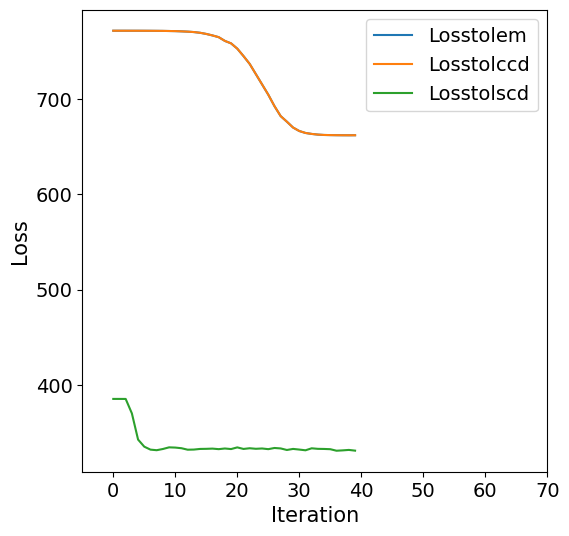

In [129]:
fig = plt.figure(figsize=(6, 6))
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.plot(Losstolem, label="Losstolem")
plt.plot(Losstolccd, label="Losstolccd")
plt.plot(Losstolscd, label="Losstolscd")
plt.xlim(-5, 70)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [130]:
#TopicModelIllustration
mj_tp,Lp=simu_load(20,5)
Fp=simu_fact(30,5)
s=simu_size(20)
Xmulti=simu_multi_counts(Lp,Fp,s)
order_loading=np.lexsort((mj_tp,Lp[:,0]))
Fp,Lp,lossp=init_poissnmf(Xmulti,Fp,Lp,5)

In [131]:
Fp

array([[0.97042043, 0.86882472, 0.62927231, 0.76791002, 0.21146283],
       [0.35251241, 0.69086249, 0.83660927, 0.95022099, 0.14476104],
       [0.71223042, 0.72392691, 0.89192811, 0.39614543, 0.20499577],
       [0.67326869, 0.81847794, 0.96897081, 0.72465609, 0.49828528],
       [0.77978057, 0.6013814 , 0.41050759, 0.35781799, 0.36065636],
       [0.22066281, 0.24166938, 0.76288192, 0.24236788, 0.99591059],
       [0.0407678 , 0.62937802, 0.91970117, 0.36925167, 0.36649322],
       [0.33177544, 0.82077722, 0.44758795, 0.71091002, 0.218218  ],
       [0.14088723, 0.87001841, 0.74625608, 0.93757126, 0.96901113],
       [0.03427841, 0.31862287, 0.41213736, 0.78098623, 0.458179  ],
       [0.47677599, 0.10212901, 0.45819294, 0.02214377, 0.76189994],
       [0.71784655, 0.29641657, 0.72818004, 0.5537745 , 0.26180498],
       [0.72146672, 0.24119952, 0.13962792, 0.85355852, 0.38048376],
       [0.0247476 , 0.64004958, 0.48676702, 0.69169794, 0.90329111],
       [0.52583007, 0.6255329 , 0.

In [132]:
Lp

array([[0.74671001, 0.84660823, 0.03942481, 0.11034087, 0.8136977 ],
       [0.74965478, 0.71279297, 0.40921455, 0.68030991, 0.86239267],
       [0.53663143, 0.19083318, 0.61332302, 0.20632575, 0.93244515],
       [0.36769989, 0.54648702, 0.55667885, 0.35890992, 0.86116655],
       [0.79897769, 0.05461635, 0.5977637 , 0.40291372, 0.83923008],
       [0.54561701, 0.97667112, 0.42503102, 0.76582911, 0.97023309],
       [0.61893191, 0.19159477, 0.35680625, 0.9871556 , 0.76865493],
       [0.17941371, 0.52954611, 0.76155954, 0.60198937, 0.08096672],
       [0.63887008, 0.65928311, 0.88273497, 0.21391401, 0.71179062],
       [0.57882321, 0.58131918, 0.16435726, 0.18056088, 0.14459412],
       [0.72043117, 0.49170216, 0.18539057, 0.51861452, 0.908161  ],
       [0.32650908, 0.52611767, 0.69147503, 0.64095959, 0.02056476],
       [0.78772702, 0.62453119, 0.83165562, 0.21313634, 0.81624284],
       [0.46647433, 0.35374177, 0.3189585 , 0.13907687, 0.34273018],
       [0.15037529, 0.15804735, 0.

In [133]:
L1,F1,loss1=imple_poissnmf(Xmulti,Lp,Fp,"EM",10)

In [134]:
L2,F2,loss2=imple_poissnmf(Xmulti,Lp,Fp,"EM",30)

In [135]:
L3,F3,loss3=imple_poissnmf(Xmulti,L1,F1,"SCD",20)

In [136]:
F1mult,L1mult,sum1=poiss_multin(F1,L1)
F2mult,L2mult,sum2=poiss_multin(F2,L2)
F3mult,L3mult,sum3=poiss_multin(F3,L3)

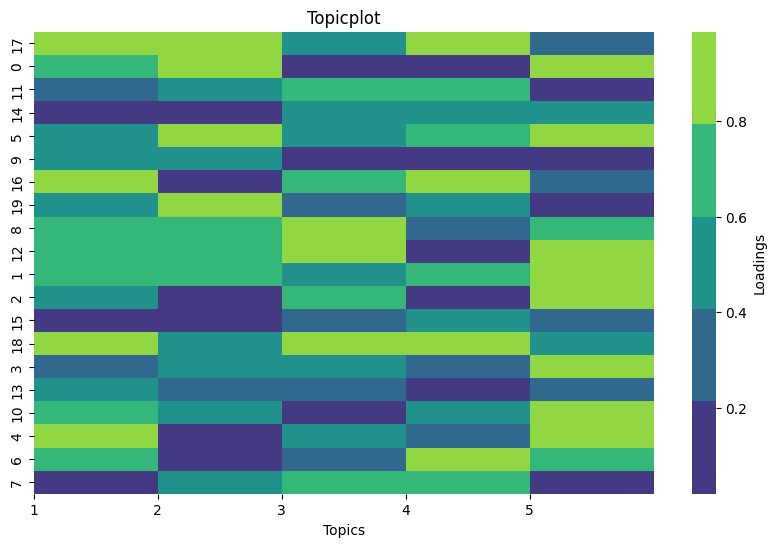

In [137]:
##True
topic_plot(Lp,order_loading,top_color="viridis",plotitle="Topicplot",k=5)

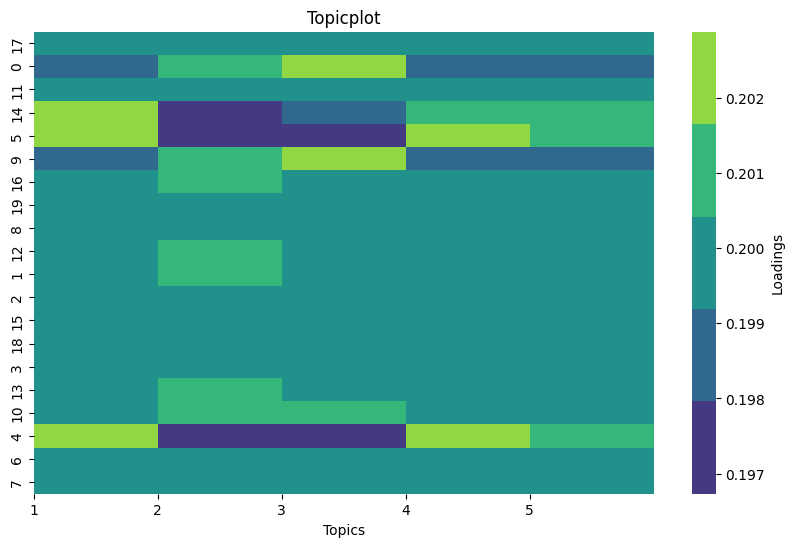

In [138]:
topic_plot(L1mult,order_loading,top_color="viridis",plotitle="Topicplot",k=5)

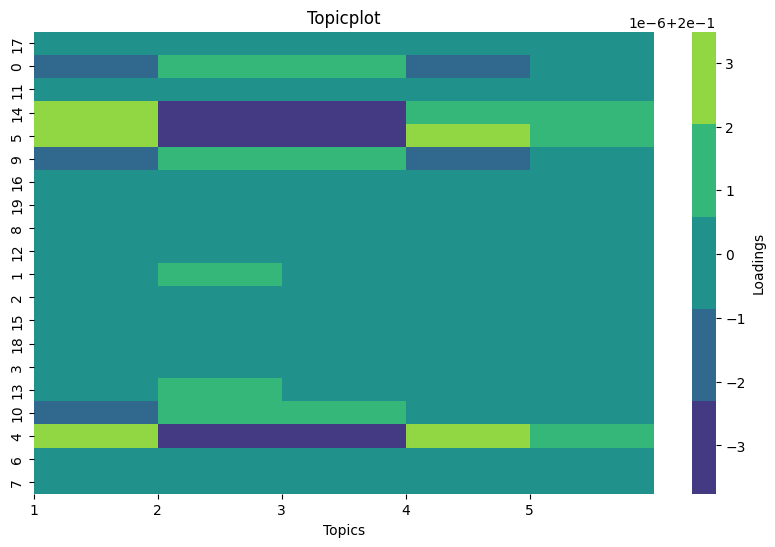

In [139]:
topic_plot(L2mult,order_loading,top_color="viridis",plotitle="Topicplot",k=5)

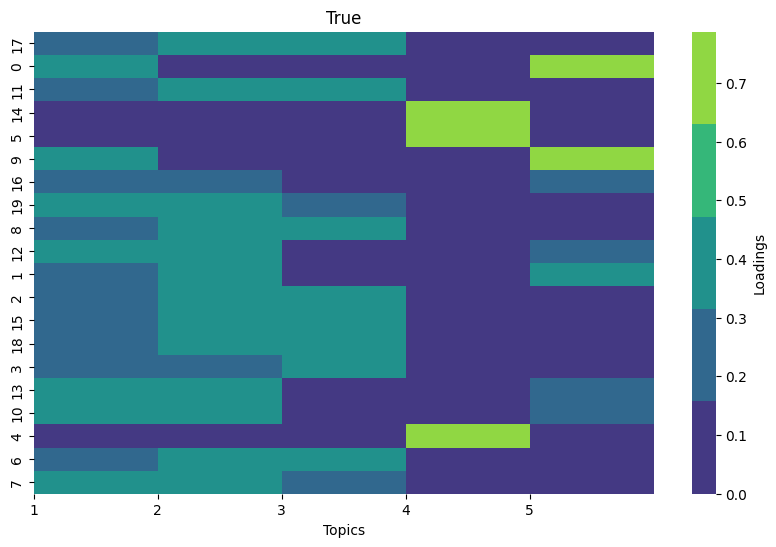

In [140]:
topic_plot(L3mult,order_loading,top_color="viridis",plotitle="True",k=5)

In [141]:
L1da,F1da,elbo1da=VEM_LDA(Xmulti,F1,L1,20)
L2da,F2da,elbo2da=VEM_LDA(Xmulti,F2,L2,20)
L3da,F3da,elbo3da=VEM_LDA(Xmulti,F3,L3,20)

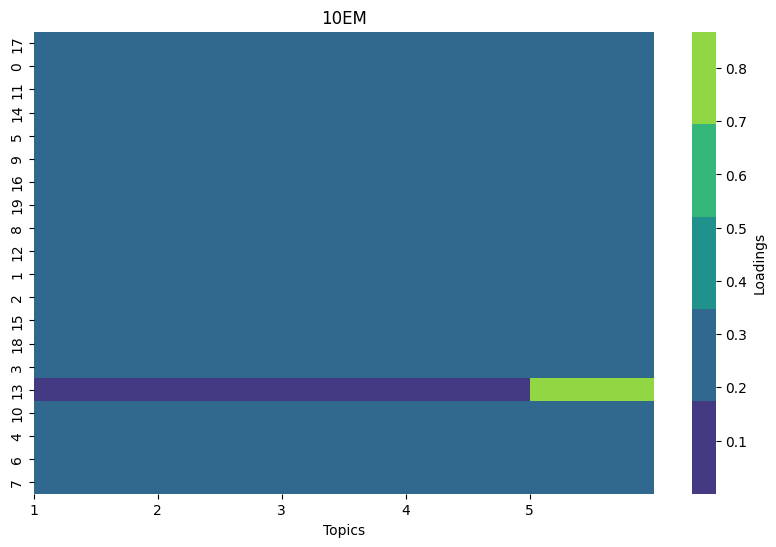

In [142]:
topic_plot(L1da,order_loading,top_color="viridis",plotitle="10EM",k=5)

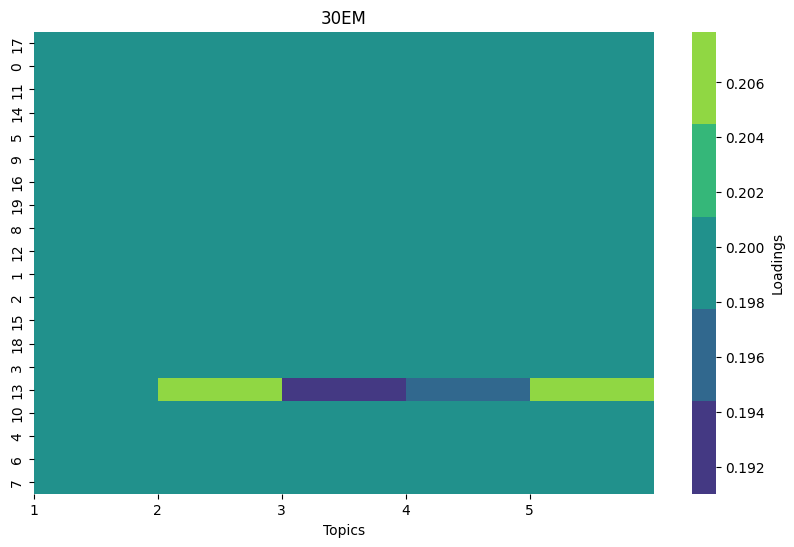

In [143]:
topic_plot(L2da,order_loading,top_color="viridis",plotitle="30EM",k=5)

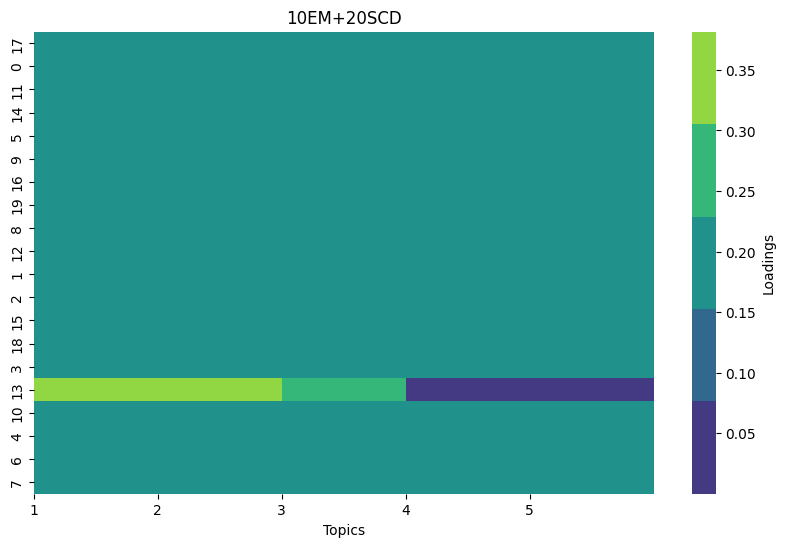

In [144]:
topic_plot(L3da,order_loading,top_color="viridis",plotitle="10EM+20SCD",k=5)

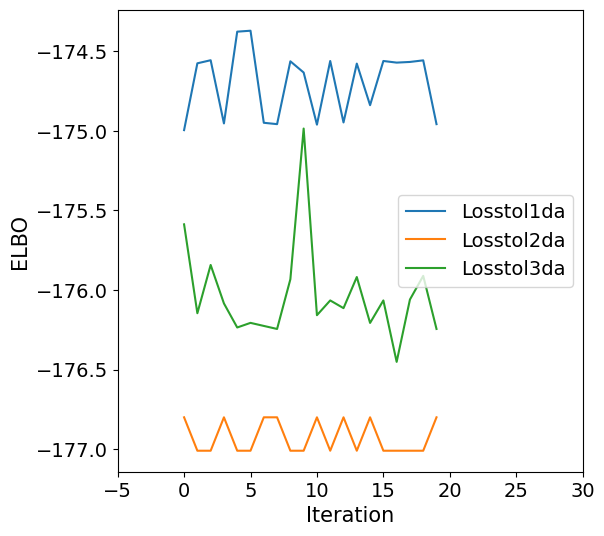

In [145]:
fig = plt.figure(figsize=(6, 6))
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("ELBO", fontsize=15)
plt.plot(elbo1da, label="Losstol1da")
plt.plot(elbo2da, label="Losstol2da")
plt.plot(elbo3da, label="Losstol3da")
plt.xlim(-5, 30)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()